In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())


<br><br><br>

##  Natural Language Processing
### :::: Representing Words ::::

<br><br><br><br><br><br>

## Word representations

Up to now, we've represented words by simply mapping them to a unique column index. 

E.g., the document "happy" becomes

$$[0,0,1,0,\ldots,0]$$

where "happy" is assigned index 2.

<br><br>
However, this representation ignores any similarity between related words.

E.g., "glad" may be

$$[0,0,0,0,0,0,1,\ldots,0]$$

where "glad" is assigned index 6

There is no way for us to tell that "happy" and "glad" are similar terms using this word representation.

<br><br>

<u> Why does this matter? </u>

- **Reason 1: Statistical efficiency**

Recall our logistic regression model, which has a separate coefficient $\theta_j$ for each term $w_j$

We would expect the coefficient $\theta_{\mathrm{glad}}$ to be similar to the coefficient $\theta_{\mathrm{happy}}$.

Or, perhaps we could collapse these coefficients into a single $\theta_{\mathrm{positive\_emotion}}$

Recall that the quality of our estimates for each $\theta_j$ depends in part on the number of training examples containing term $w_j$. By collapsing terms, or enforcing that similar terms have similar coefficients, we can make more efficient use of the limited training data we have.

<br><br>

- **Reason 2: Out-of-vocabulary words**

Given our limited training data, there are many words which may appear in the testing data but not the training data.

E.g., "elated" has no corresponding $\theta$ coefficient if it does not appear in the training data.

Even more important for informal text (SMS, social media) where abbreviations, emoticons, and neologisms abound.

## Language models, revisited

Recall the ngram language model: 

$$p(w_i \mid w_{i-1} \ldots w_{i-n})$$


One way to represent words is to summarize the contexts in which they appear.

<u>Assumption</u>: words that appear in similar contexts have similar semantics or syntactic functions.

E.g., what are the most probable words $p(w_i \mid \mathrm{"I\: feel\: so"})$?
 - happy
 - glad
 - **sad**
 
<br><br>
How do we formalize this?


<u> Idea:</u> represent each word as a vector of values
- Words with similar vectors should be similar

## Language models as classification

$$p(w_i \mid w_{i-1} \ldots w_{i-n})$$

Predict word $w_i$ given as "features" the prior $n$ words.


Any classifier can be used (Naive Bayes, logistic regression, neural nets, ...)
- class labels: all possible words in the vocabulary (multi-class classification)
- features: the words that appear around word $w_i$

In [24]:
docs = ['I am Sam',
        'You are Sam',
        'Sam I am',
        'I do not like green eggs and ham',
        'Sam I was',
        'I am Dan',
       ]

In [25]:
from collections import Counter

def iter_ngrams(doc, n):
    """Return a generator over ngrams of a document.
    Params:
      doc...list of tokens
      n.....size of ngrams"""
    return (doc[i : i+n] for i in range(len(doc)-n+1))

def iterate_examples(docs, n):
    for doc in docs:
        for ngram in iter_ngrams(doc.split(), n): 
            yield ngram[:-1], ngram[-1]
            
            
[x for x in iterate_examples(docs, 3)]

[(['I', 'am'], 'Sam'),
 (['You', 'are'], 'Sam'),
 (['Sam', 'I'], 'am'),
 (['I', 'do'], 'not'),
 (['do', 'not'], 'like'),
 (['not', 'like'], 'green'),
 (['like', 'green'], 'eggs'),
 (['green', 'eggs'], 'and'),
 (['eggs', 'and'], 'ham'),
 (['Sam', 'I'], 'was'),
 (['I', 'am'], 'Dan')]

In [26]:
# DictVectorizer: useful for creating sparse matrices from a list of dicts.

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X = vec.fit_transform([
                        {'a': 10, 'b': 1},
                        {'b': 100, 'c': 1000},
                      ])
print('feature names:\n', vec.get_feature_names_out())
print('feature matrix:\n', X.todense())

feature names:
 ['a' 'b' 'c']
feature matrix:
 [[  10.    1.    0.]
 [   0.  100. 1000.]]


In [27]:
import numpy as np

# Convert preceeding terms into a single feature per instance.
# E.g., ["I", "am"] -> "I_am" 
vec = DictVectorizer()
X = vec.fit_transform({'_'.join(x[0]): 1} for x in iterate_examples(docs, 3))
y = np.array([x[1] for x in iterate_examples(docs, 3)])
display(pd.DataFrame(np.column_stack((X.todense(), y)),
                     columns=np.concatenate((vec.get_feature_names_out(), ['label']))))

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sam
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sam
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,am
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,not
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,like
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,green
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,eggs
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,and
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ham
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,was


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X, y)
df = pd.DataFrame(clf.coef_, 
                  columns=vec.get_feature_names_out(), 
                  index=clf.classes_)
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.685074,-0.077818,-0.145726,-0.072496,-0.077818,-0.077818,-0.077818,-0.077818,-0.077818
Sam,0.475546,-0.148854,-0.265479,0.683047,-0.148854,-0.148854,-0.148854,-0.148854,-0.148854
am,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217
and,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,0.798410,-0.083461,-0.083461
eggs,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,0.798410,-0.083461
green,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,0.798410
ham,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,0.798410,-0.083461,-0.083461,-0.083461
like,-0.147695,-0.083461,-0.155626,-0.077780,0.798410,-0.083461,-0.083461,-0.083461,-0.083461
not,-0.147695,0.798410,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,-0.083461
was,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217


In [29]:
# Can now use the classifier to predict the next word, 
# given the previous words.
i_am = vec.transform({'I_am': 1})
print(clf.predict(i_am))
display(pd.DataFrame(zip(clf.classes_, clf.predict_proba(i_am)[0])))

['Sam']


,0,1
0,Dan,0.157443
1,Sam,0.262232
2,am,0.068615
3,and,0.073849
4,eggs,0.073849
5,green,0.073849
6,ham,0.073849
7,like,0.073849
8,not,0.073849
9,was,0.068615


## Insight

- Each word $w_i$ has a separate $\theta_i$ vector in the classifier.
- High values $\theta_{ij} \in \theta_i$ means that bigram $j$ is predictive of word $i$
- Perhaps words with similar vectors are also similar?
  - Appear in similar contexts

In [30]:
# Which preceding bigrams are predictive of Dan?
df.loc['Dan'].sort_values(ascending=False)

I_am          0.685074
You_are      -0.072496
I_do         -0.077818
do_not       -0.077818
eggs_and     -0.077818
like_green   -0.077818
green_eggs   -0.077818
not_like     -0.077818
Sam_I        -0.145726
Name: Dan, dtype: float64

In [31]:
# Which preceding bigrams are predictive of Sam?
df.loc['Sam'].sort_values(ascending=False)

You_are       0.683047
I_am          0.475546
I_do         -0.148854
do_not       -0.148854
eggs_and     -0.148854
like_green   -0.148854
green_eggs   -0.148854
not_like     -0.148854
Sam_I        -0.265479
Name: Sam, dtype: float64

In [32]:
# Which preceding bigrams are predictive of like?
df.loc['like'].sort_values(ascending=False)

do_not        0.798410
You_are      -0.077780
like_green   -0.083461
I_do         -0.083461
eggs_and     -0.083461
not_like     -0.083461
green_eggs   -0.083461
I_am         -0.147695
Sam_I        -0.155626
Name: like, dtype: float64

<br><br>

## Interlude: Interpreting coefficients

In **linear regression** it is fairly straightforward to interpret what $\theta_i$ means:

$$y = \sum_i x_i \cdot \theta_i$$

> for every unit increase in $x_i$, $y$ increases by $\theta_i$

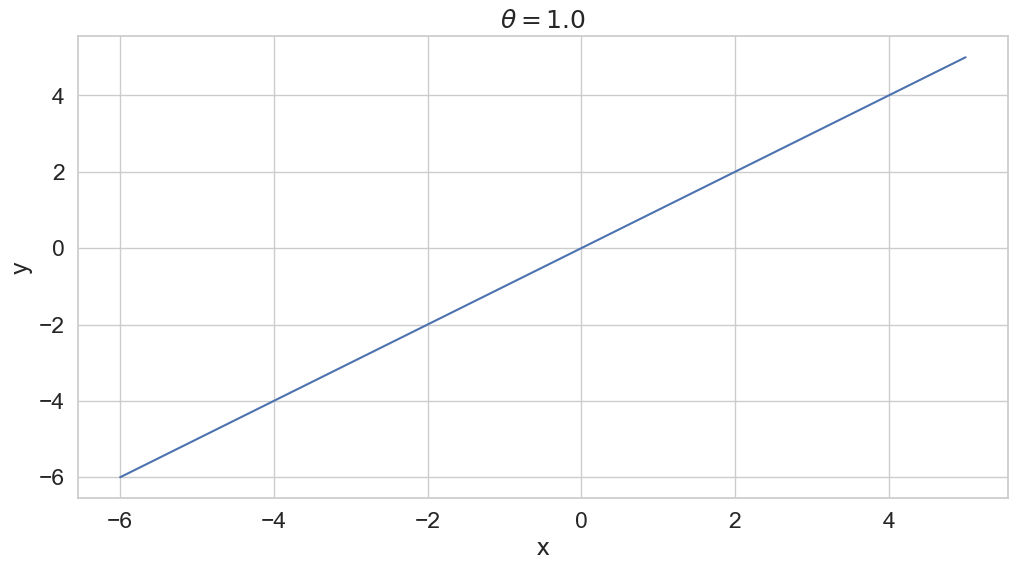

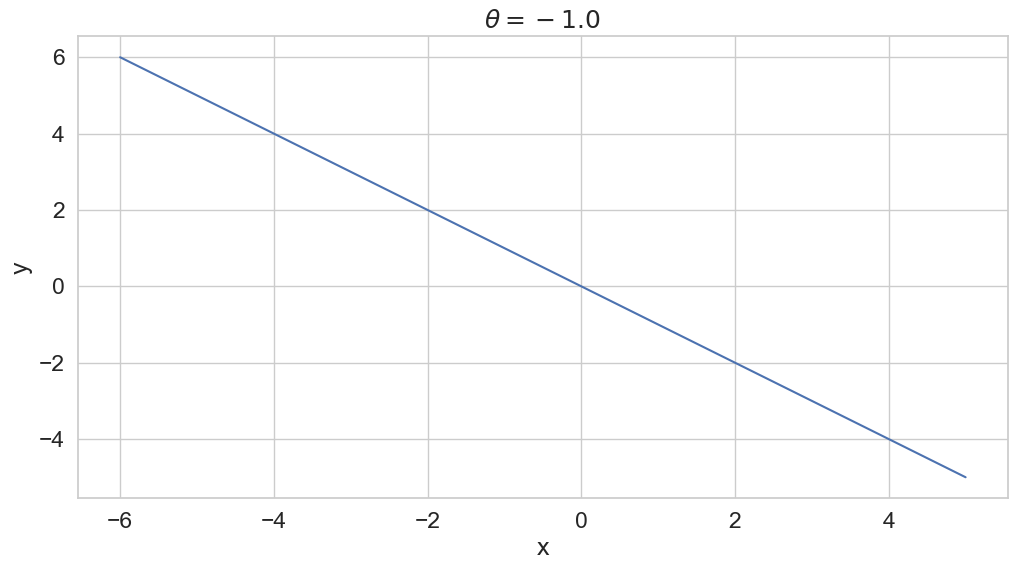

In [33]:
x = np.arange(-6, 6)
theta=.2

def plot_linear(x, theta):
    plt.figure()
    plt.plot(x, x*theta)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$\theta=%.1f$' % theta)
    plt.show()

plot_linear(x, 1)
plot_linear(x, -1)


But the relationship between $\theta$ and $y$ is nonlinear for logistic regression:


$$y = \frac{1}{1 + e^{-\sum_i x_i \cdot \theta_i}}$$

> for every unit increase in $x_i$, $y$ increases by ?


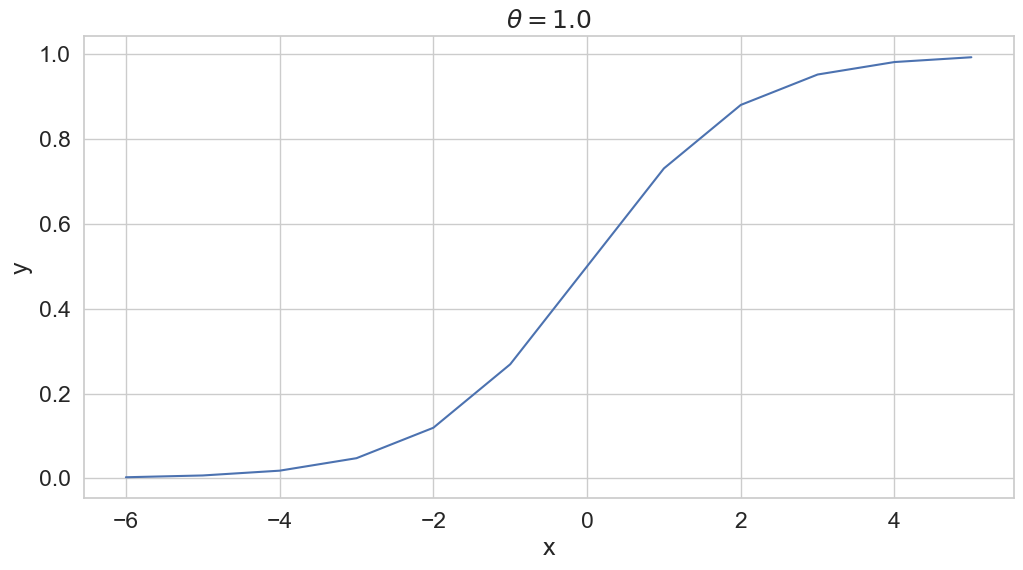

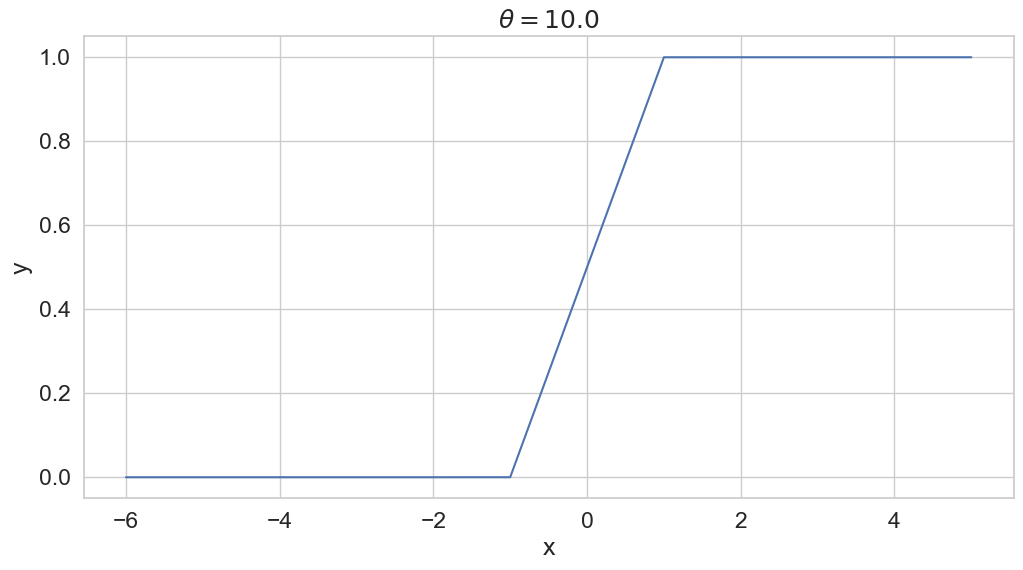

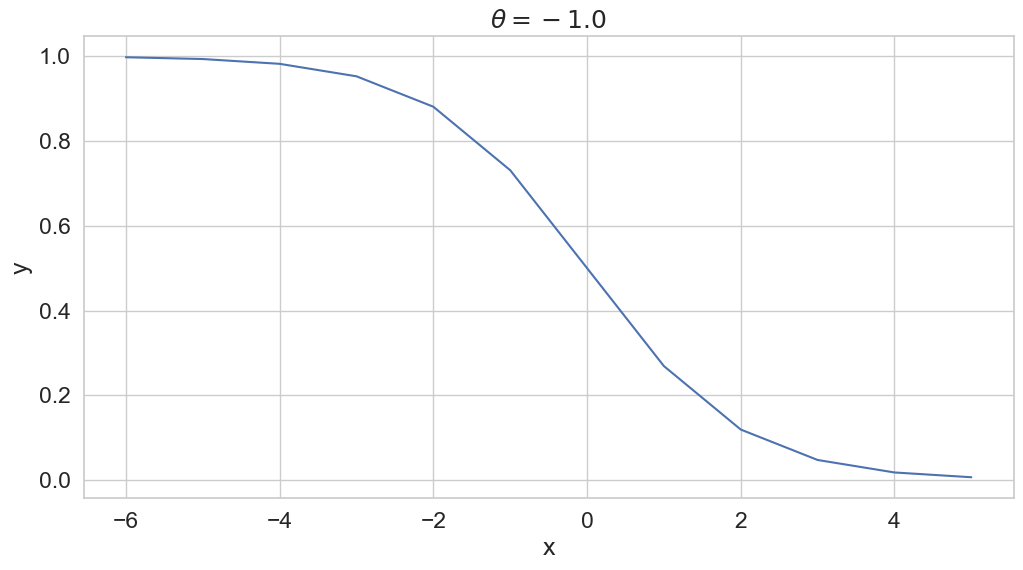

In [34]:
import math

def logistic(xi, theta):
    return 1 / (1 + math.exp(-xi*theta))
    
def plot_logistic(x, theta):    
    plt.figure()
    plt.plot(x, [logistic(xi, theta) for xi in x])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$\theta=%.1f$' % theta)
    plt.show()

x = np.arange(-6, 6)
plot_logistic(x, 1)
plot_logistic(x, 10)
plot_logistic(x, -1)

<br>

The shape of these graphs imply that the relationship between $\theta$ and $y$ depends on $x$. 

E.g., $\theta$ changes the probability of $y$ more when $x$ is near $0$ than when it is near $4$.

<br>

One way to interpret logistic regression coefficients is in terms of **odds**.

If probability of positive class is $p \equiv p(y|\vec{x})$, then the **odds** of the positive class is $\frac{p}{1-p}$

E.g., an odds of $2$ means the positive class is twice as likely as the negative class.




In [35]:
def odds(p):
    return p / (1-p)

pd.DataFrame([(pi, odds(pi)) for pi in np.arange(10)/10], columns=['p', 'odds'])

,p,odds
0,0.0,0.000000
1,0.1,0.111111
2,0.2,0.250000
3,0.3,0.428571
4,0.4,0.666667
5,0.5,1.000000
6,0.6,1.500000
7,0.7,2.333333
8,0.8,4.000000
9,0.9,9.000000


With some arithmetic, we can rewrite the logistic function as:

$$\log \Big(\frac{p}{1-p} \Big) = \sum_i x_i \theta_i $$

This means we can interpret $\theta_i$ as the log of the odds of the positive class.

Equivalently, $e^{\theta_i}$ is the odds of the positive class.

So, if $\theta_i=0.5$, then $e^{0.5} \approx 1.65$  means that the odds for a document containing word $i$ being positive is about 65% higher than a document without word $i$, all else being equal.



<br><br>

... back to our classifier:

In [36]:
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.685074,-0.077818,-0.145726,-0.072496,-0.077818,-0.077818,-0.077818,-0.077818,-0.077818
Sam,0.475546,-0.148854,-0.265479,0.683047,-0.148854,-0.148854,-0.148854,-0.148854,-0.148854
am,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217
and,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,0.798410,-0.083461,-0.083461
eggs,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,0.798410,-0.083461
green,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,0.798410
ham,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,0.798410,-0.083461,-0.083461,-0.083461
like,-0.147695,-0.083461,-0.155626,-0.077780,0.798410,-0.083461,-0.083461,-0.083461,-0.083461
not,-0.147695,0.798410,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,-0.083461
was,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217


<br><br>

How can we compute the similarity between such vectors?

### Cosine similarity

A common way of measuring similarity between vectors:

$$ cos(x, y) = \frac{\sum_{i} x_i * y_i}{\sqrt{\sum_i x_i^2} \sqrt{\sum_i y_i^2}}$$

$cos(x,y) = 1 \rightarrow$ $x$ and $y$ are identical  
$cos(x,y) = -1 \rightarrow$ $x$ and $y$ are opposite

![cos](figs/cos.png)

In [40]:
# Are words with similar coefficients related?
from math import sqrt

def similarity(word1, word2, clf):
    # find the coefficient vector for each word
    i1 = list(clf.classes_).index(word1)
    i2 = list(clf.classes_).index(word2)
    coef1 = clf.coef_[i1]
    coef2 = clf.coef_[i2]
    # compute cosine similarity
    return np.dot(coef1, coef2) / (sqrt(np.dot(coef1, coef1)) * sqrt(np.dot(coef2, coef2)))
    
similarity('Sam', 'Dan', clf)

0.5567280650261338

In [39]:
similarity('Sam', 'like', clf)

-0.17224819400768715

We can do the same using a neural network, though now we will also have a hidden layer.

In [41]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
                    activation='logistic',
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=1234)

mlp.fit(X, y)
mlp.coefs_

[array([[-0.68579308, -0.04234696, -0.17227536,  0.7473541 ,  0.08192718,
         -0.27193579, -0.23608068, -0.69872155,  1.25562415, -0.48022638,
         -0.49063975, -1.11987265, -0.28252406, -0.16242919,  1.06836962,
         -0.39818186, -0.34072692, -0.04195113, -0.16993717,  0.27029782,
         -1.19812692,  0.45863571, -0.64155897, -0.87949982,  0.49187655,
          0.09869887,  0.1549649 ,  1.11757156, -0.3089508 , -0.96330477,
          1.54764713,  0.72843589, -0.06373038, -0.66283442,  0.73139875,
          0.52165141,  0.07349966,  1.24445797, -0.13569704,  0.98180907,
         -0.06499636, -0.03612171,  0.46240184,  0.45553545,  0.90395705,
         -0.27980769,  0.71340881,  0.61582856,  0.6621786 ,  1.09414684,
         -0.75466383,  1.14428232,  0.35935364, -1.39996323, -0.16999424,
          0.68383684,  0.54800623,  1.22423527,  0.49409309,  0.0036013 ,
         -0.50490803,  0.61206789, -0.02014888, -0.98130013, -0.35061149,
         -0.58265385, -0.9656871 ,  0.

## Word vectors

If we run the above approach on a very large, unlabeled dataset, we can associate a parameter vector $\theta_i$ with each word $i$.

We can use this vector to represent each word.

In [21]:
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.685074,-0.077818,-0.145726,-0.072496,-0.077818,-0.077818,-0.077818,-0.077818,-0.077818
Sam,0.475546,-0.148854,-0.265479,0.683047,-0.148854,-0.148854,-0.148854,-0.148854,-0.148854
am,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217
and,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,0.798410,-0.083461,-0.083461
eggs,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,0.798410,-0.083461
green,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,0.798410
ham,-0.147695,-0.083461,-0.155626,-0.077780,-0.083461,0.798410,-0.083461,-0.083461,-0.083461
like,-0.147695,-0.083461,-0.155626,-0.077780,0.798410,-0.083461,-0.083461,-0.083461,-0.083461
not,-0.147695,0.798410,-0.155626,-0.077780,-0.083461,-0.083461,-0.083461,-0.083461,-0.083461
was,-0.137225,-0.077217,0.672481,-0.071934,-0.077217,-0.077217,-0.077217,-0.077217,-0.077217


<u>Problems with this approach?</u>

<br><br><br>

- **Scalability**: for an ngram model, we must have a different parameter for every distinct ngram in the data
- **Sparsity**: for a given word, only a small number of ngram features will be present. E.g.:
  - "I am so happy" 
  - "You are super glad"
  - In this example, there would be no feature overlap, reducing the similarity between "happy" and "glad"
  
  
<u> Solution </u>
- Use a small, dense vector to represent each word.
- When computing features, use this word vector to represent preceding words, rather than the words themselves.


$p(w_i \mid w_{i-1} \ldots w_{i-n})$ becomes  
$p(w_i \mid v_{i-1} \ldots v_{i-n})$  
where $v_i$ is the vector representation of word $i$.

<u> Objective </u>

Jointly learn parameters and <u>word representation</u> to enable prediction of $p(w_i \mid v_{i-1} \ldots v_{i-n})$.

In [42]:
# E.g., fix dimension of each word vector to 3
# Initialze to small random values in [-.1, .1]
vec_dim = 3
np.random.seed(1234)
word_vectors = np.random.uniform(-.1, .1, (len(clf.classes_), 3))
word_vectors = pd.DataFrame(word_vectors, index=clf.classes_)
word_vectors
# Want to update these parameters so that similar words have similar values.

,0,1,2
Dan,-0.061696,0.024422,-0.012454
Sam,0.057072,0.055995,-0.045481
am,-0.044707,0.060374,0.091628
and,0.075187,-0.028437,0.000199
eggs,0.036693,0.042540,-0.025950
green,0.012239,0.000617,-0.097246
ham,0.054565,0.076528,-0.027023
like,0.023079,-0.084924,-0.026235
not,0.086628,0.030276,-0.020559
was,0.057746,-0.036633,0.013620


<br><br><br>

## Feature representation
To represent features in classifier: 
$p(w_i \mid v_{i-1} \ldots v_{i-n})$  

we will concatenate the vectors for each prior word.

E.g.  features for
$p(w_i \mid \mathrm{green\: eggs})$ :


In [45]:
np.concatenate((word_vectors.loc['green'],
                word_vectors.loc['eggs']))

array([ 0.01223924,  0.00061663, -0.09724631,  0.03669259,  0.04254041,
       -0.02594985])

But, how will we optimize these vectors?

Just doing logistic regression will associate weights with each vector element, but not change the word representations.



<u> Neural nets to the rescue! </u>

![nn](figs/nn.png)

- Word vectors become hidden nodes in a neural network.
- An additional hidden layer allows non-linear transformations of word vectors
- Training the model to optimize $p(w_i \mid v_{i-1} \ldots v_{i-n})$ results in "useful" vectors for $v$.

## Other architectures

There have been many architectures proposed to learn useful word vectors:

$p(w_i \mid w_1 \ldots w_n)$ (before and after context)

![cbow](figs/cbow.png)

$p(w_1 \ldots w_n \mid w_i)$ (predict context given current word)

![skip](figs/skip.png)

## Visualizing word vectors

![vis1.jpg](figs/vis1.jpg)

![vis2.jpg](figs/vis2.png)

![vis3.jpg](figs/vis3.png)



**image sources**

- https://engineering.aweber.com/cosine-similarity/
- http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf
- https://deeplearning4j.org/img/countries_capitals.png
- https://adriancolyer.files.wordpress.com/2016/04/word2vec-gender-relation.png?w=600